In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

def make_catndog_dataframe():
    paths = []
    dataset_gubuns = []
    label_gubuns = []
    # os.walk()를 이용하여 특정 디렉토리 밑에 있는 모든 하위 디렉토리를 모두 조사. 
    # cat-and-dog 하위 디렉토리 밑에 jpg 확장자를 가진 파일이 모두 이미지 파일임
    # cat-and-dog 밑으로 /train/, /test/ 하위 디렉토리 존재(학습, 테스트 용 이미지 파일들을 가짐)

    for dirname, _, filenames in os.walk('../../data/catanddog'):
        for filename in filenames:
            # 이미지 파일이 아닌 파일도 해당 디렉토리에 있음.
            if '.jpg' in filename:
                # 파일의 절대 경로를 file_path 변수에 할당. 
                file_path = dirname+'/'+ filename
                paths.append(file_path)
                # 파일의 절대 경로에 training_set, test_set가 포함되어 있으면 데이터 세트 구분을 'train'과 'test'로 분류. 
                if '\\training_set\\' in file_path:
                    dataset_gubuns.append('train')  
                elif '\\test_set\\' in file_path:
                    dataset_gubuns.append('test')
                else: dataset_gubuns.append('N/A')

                # 파일의 절대 경로에 dogs가 있을 경우 해당 파일은 dog 이미지 파일이고, cats일 경우는 cat 이미지 파일임. 
                if 'dogs' in file_path:
                    label_gubuns.append('DOG')
                elif 'cats' in file_path:
                    label_gubuns.append('CAT')
                else: label_gubuns.append('N/A')
    
    data_df = pd.DataFrame({'path':paths, 'dataset':dataset_gubuns, 'label':label_gubuns})
    return data_df

In [2]:
pd.set_option('display.max_colwidth', 200)
data_df = make_catndog_dataframe()
print('data_df shape:', data_df.shape)
data_df.head()

data_df shape: (10028, 3)


,path,dataset,label
0,../../data/catanddog\test_set\test_set\cats/cat.4001.jpg,test,CAT
1,../../data/catanddog\test_set\test_set\cats/cat.4002.jpg,test,CAT
2,../../data/catanddog\test_set\test_set\cats/cat.4003.jpg,test,CAT
3,../../data/catanddog\test_set\test_set\cats/cat.4004.jpg,test,CAT
4,../../data/catanddog\test_set\test_set\cats/cat.4005.jpg,test,CAT


### Keras Sequence를 상속받은 Dataset 객체를 생성

In [19]:
from tensorflow.keras.utils import Sequence
import sklearn
import cv2

BATCH_SIZE = 8
IMAGE_SIZE = 224 

class CnD_Dataset(Sequence):
    
    def __init__(self, image_filenames, labels, batch_size=BATCH_SIZE, augmentor=None, shuffle=False):
        self.image_filenames = image_filenames
        self.labels = labels
        self.batch_size = batch_size
        self.augmentor = augmentor
        self.shuffle = shuffle
        
        if self.shuffle:
            pass
        
    def __len__(self):
        return int(np.ceil(len(self.labels)/self.batch_size))
    
    def __getitem__(self, index):
        image_name_batch = self.image_filenames[index*self.batch_size:(index+1)*self.batch_size]
        if self.labels is not None:
            label_batch = self.labels[index*self.batch_size:(index+1)*self.batch_size]
        image_batch = np.zeros((image_name_batch.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
        for image_index in range(image_batch.shape[0]):
            image = cv2.cvtColor(cv2.imread(image_name_batch[image_index]), cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
            if self.augmentor is not None:
                image = self.augmentor(image=image)['image']

            image_batch[image_index] = image
            
        return image_batch, label_batch   
            
    def on_epoch_end(self):
        if(self.shuffle):
            self.image_filenames, self.labels = sklearn.utils.shuffle(self.image_filenames, self.labels)
        else:
            pass

### Sequence 기반 Dataset을 생성하고 호출하기
* albumentations를 이용하여 BATCH 크기 만큼 데이터를 Augmentation 한 뒤 데이터를 반환 할 수 있는 Sequence 기반 Dataset을 생성하고 호출하기 

In [20]:
data_df.head()

,path,dataset,label
0,../../data/catanddog\test_set\test_set\cats/cat.4001.jpg,test,CAT
1,../../data/catanddog\test_set\test_set\cats/cat.4002.jpg,test,CAT
2,../../data/catanddog\test_set\test_set\cats/cat.4003.jpg,test,CAT
3,../../data/catanddog\test_set\test_set\cats/cat.4004.jpg,test,CAT
4,../../data/catanddog\test_set\test_set\cats/cat.4005.jpg,test,CAT


In [21]:
import albumentations as A

# 전체 데이터 세트에서 학습과 테스트용 메타 정보 DataFrame 생성. 
train_df = data_df[data_df['dataset']=='train']
test_df = data_df[data_df['dataset']=='test']

# image file의 위치가 있는 데이터와 label값을 numpy array로 변환. 
train_image_filenames = train_df['path'].values
train_image_labels = train_df['label'].values

cnd_augmentor = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(p=0.5)
])

# Sequence를 상속받은 CnD_Dataset을 image 파일 위치, label값, albumentations 변환 객체를 입력하여 생성. 
cnd_ds = CnD_Dataset(train_image_filenames, train_image_labels, batch_size=BATCH_SIZE, augmentor=cnd_augmentor, shuffle=False)

In [23]:
train_image_filenames.shape

(8005,)

In [22]:
#next(iter(cnd_ds))
images_batch = next(iter(cnd_ds))[0]
labels_batch = next(iter(cnd_ds))[1]
print(images_batch.shape, labels_batch.shape)
print(images_batch[0])

(8, 224, 224, 3) (8,)
[[[ 24.  22.  22.]
  [ 23.  22.  22.]
  [ 22.  22.  22.]
  ...
  [ 49.  33.  26.]
  [ 42.  26.  20.]
  [ 41.  29.  21.]]

 [[ 23.  21.  22.]
  [ 21.  21.  21.]
  [ 21.  21.  21.]
  ...
  [ 55.  39.  33.]
  [ 52.  37.  30.]
  [ 50.  37.  29.]]

 [[ 22.  20.  21.]
  [ 19.  19.  19.]
  [ 19.  19.  19.]
  ...
  [ 50.  34.  28.]
  [ 54.  40.  33.]
  [ 55.  43.  34.]]

 ...

 [[ 45.  50.  53.]
  [ 40.  49.  51.]
  [ 38.  51.  54.]
  ...
  [ 72.  77. 100.]
  [ 72.  77. 101.]
  [ 68.  73.  98.]]

 [[ 46.  51.  52.]
  [ 36.  46.  46.]
  [ 38.  53.  53.]
  ...
  [ 71.  75.  99.]
  [ 72.  77. 101.]
  [ 66.  72.  96.]]

 [[ 45.  50.  51.]
  [ 34.  45.  44.]
  [ 39.  54.  52.]
  ...
  [ 70.  74.  99.]
  [ 69.  74.  99.]
  [ 64.  70.  95.]]]


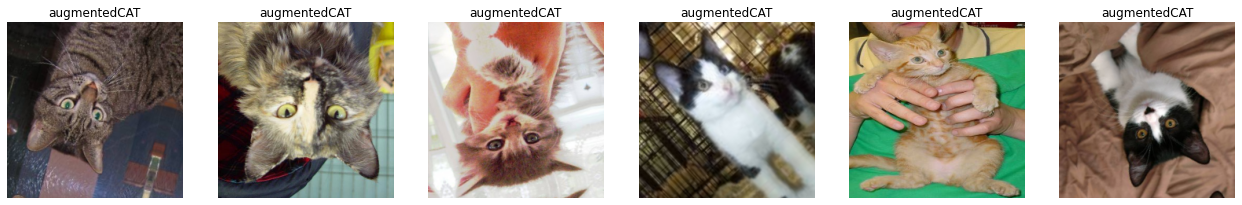

In [30]:
import matplotlib.pyplot as plt

def show_grid_images(images_batch, ncols=4, title=None):
    figure, axs = plt.subplots(figsize=(22, 4), nrows=1, ncols=ncols)
    for i in range(ncols):
        axs[i].imshow(np.array(images_batch[i], dtype='int32'))
        axs[i].axis('off')
        axs[i].set_title(title[i])
        
show_grid_images(images_batch, ncols=6, title='augmented' + labels_batch)

### 원본 이미지 픽셀값의 scaling을 감안하여 다시 CnD_Dataset 재 작성. 

In [34]:
class CnD_Dataset(Sequence):
    def __init__(self, image_filenames, labels, batch_size=BATCH_SIZE, augmentor=None, shuffle=False):
        '''
        파라미터 설명
        image_filenames: opencv로 image를 로드할 파일의 절대 경로들
        labels: 해당 image의 label들
        batch_size: __getitem__(self, index) 호출 시 마다 가져올 데이터 batch 건수
        augmentor: albumentations 객체
        shuffle: 학습 데이터의 경우 epoch 종료시마다 데이터를 섞을지 여부
        '''
        # 객체 생성 인자로 들어온 값을 객체 내부 변수로 할당. 
        self.image_filenames = image_filenames
        self.labels = labels
        self.batch_size = batch_size
        self.augmentor = augmentor
        # train data의 경우 
        self.shuffle = shuffle
        if self.shuffle:
            # 객체 생성시에 한번 데이터를 섞음. 
            #self.on_epoch_end()
            pass
    
    # Sequence를 상속받은 Dataset은 batch_size 단위로 입력된 데이터를 처리함. 
    # __len__()은 전체 데이터 건수가 주어졌을 때 batch_size단위로 몇번 데이터를 반환하는지 나타남
    def __len__(self):
        # batch_size단위로 데이터를 몇번 가져와야하는지 계산하기 위해 전체 데이터 건수를 batch_size로 나누되, 정수로 정확히 나눠지지 않을 경우 1회를 더한다. 
        return int(np.ceil(len(self.labels)/self.batch_size))
    
    # batch_size 단위로 image_array, label_array 데이터를 가져와서 변환한 뒤 다시 반환함
    # 인자로 몇번째 batch 인지를 나타내는 index를 입력하면 해당 순서에 해당하는 batch_size 만큼의 데이타를 가공하여 반환
    # batch_size 갯수만큼 변환된 image_array와 label_array 반환. 
    def __getitem__(self, index):
        # index는 몇번째 batch인지를 나타냄. 
        # batch_size만큼 순차적으로 데이터를 가져오려면 array에서 index*self.batch_size:(index+1)*self.batch_size 만큼의 연속 데이터를 가져오면 됨
        image_name_batch = self.image_filenames[index*self.batch_size:(index+1)*self.batch_size]
        if self.labels is not None:
            label_batch = self.labels[index*self.batch_size:(index+1)*self.batch_size]
        
        # 만일 객체 생성 인자로 albumentation으로 만든 augmentor가 주어진다면 아래와 같이 augmentor를 이용하여 image 변환
        # albumentations은 개별 image만 변환할 수 있으므로 batch_size만큼 할당된 image_name_batch를 한 건씩 iteration하면서 변환 수행. 
        # image_batch 배열은 float32 로 설정. 
        image_batch = np.zeros((image_name_batch.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3), dtype='float32')
        
        # batch_size에 담긴 건수만큼 iteration 하면서 opencv image load -> image augmentation 변환(augmentor가 not None일 경우)-> image_batch에 담음. 
        for image_index in range(image_name_batch.shape[0]):
            image = cv2.cvtColor(cv2.imread(image_name_batch[image_index]), cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
            if self.augmentor is not None:
                image = self.augmentor(image=image)['image']
            
            # 이미지 값을 0 ~ 1 로 스케일링. 
            image = image/255.0
                
            image_batch[image_index] = image
        
        return image_batch, label_batch
    
    # epoch가 한번 수행이 완료 될 때마다 모델의 fit()에서 호출됨. 
    def on_epoch_end(self):
        if(self.shuffle):
            #print('epoch end')
            # 전체 image 파일의 위치와 label를 쌍을 맞춰서 섞어준다. scikt learn의 utils.shuffle에서 해당 기능 제공
            self.image_filenames, self.labels = sklearn.utils.shuffle(self.image_filenames, self.labels)
        else:
            pass

In [37]:
# Sequence를 상속받은 CnD_Dataset을 image 파일 위치, label값, albumentations 변환 객체를 입력하여 생성. 
cnd_ds = CnD_Dataset(train_image_filenames, train_image_labels, batch_size=BATCH_SIZE, augmentor=cnd_augmentor, shuffle=False)

images_batch = next(iter(cnd_ds))[0]
labels_batch = next(iter(cnd_ds))[1]
print(images_batch.shape, labels_batch.shape)
print(images_batch[0:2])

(8, 224, 224, 3) (8,)
[[[[0.12156863 0.11372549 0.11764706]
   [0.10588235 0.09803922 0.10196079]
   [0.08627451 0.07843138 0.08235294]
   ...
   [0.21960784 0.16862746 0.13725491]
   [0.18039216 0.13333334 0.10196079]
   [0.16470589 0.1254902  0.09019608]]

  [[0.1254902  0.11764706 0.11764706]
   [0.10980392 0.10196079 0.10588235]
   [0.09019608 0.08235294 0.08627451]
   ...
   [0.16078432 0.10980392 0.08235294]
   [0.16078432 0.11372549 0.08627451]
   [0.20784314 0.16862746 0.13725491]]

  [[0.11764706 0.10980392 0.11372549]
   [0.10196079 0.09411765 0.10196079]
   [0.09019608 0.08235294 0.08627451]
   ...
   [0.17254902 0.12156863 0.09803922]
   [0.15294118 0.10588235 0.08235294]
   [0.19607843 0.15294118 0.12941177]]

  ...

  [[0.15294118 0.17254902 0.15686275]
   [0.15294118 0.16862746 0.16078432]
   [0.14901961 0.16470589 0.16078432]
   ...
   [0.77254903 0.75686276 0.6627451 ]
   [0.78039217 0.7607843  0.64705884]
   [0.7921569  0.77254903 0.6509804 ]]

  [[0.15686275 0.176470

### Pretrained 모델에서 사용하는 보다 범용적인 Preprocessing을 적용할 수 있도록 재작성. 
* pre_func 인자를 추가하여 pretrained 모델의 preprocess_input 함수를 인자로 입력할 수 있도록 수정. 

In [38]:
class CnD_Dataset(Sequence):
    def __init__(self, image_filenames, labels, batch_size=BATCH_SIZE, augmentor=None, shuffle=False, pre_func=None):
        '''
        파라미터 설명
        image_filenames: opencv로 image를 로드할 파일의 절대 경로들
        labels: 해당 image의 label들
        batch_size: __getitem__(self, index) 호출 시 마다 가져올 데이터 batch 건수
        augmentor: albumentations 객체
        shuffle: 학습 데이터의 경우 epoch 종료시마다 데이터를 섞을지 여부
        '''
        # 객체 생성 인자로 들어온 값을 객체 내부 변수로 할당. 
        self.image_filenames = image_filenames
        self.labels = labels
        self.batch_size = batch_size
        self.augmentor = augmentor
        self.pre_func = pre_func
        # train data의 경우 
        self.shuffle = shuffle
        if self.shuffle:
            # 객체 생성시에 한번 데이터를 섞음. 
            #self.on_epoch_end()
            pass
    
    # Sequence를 상속받은 Dataset은 batch_size 단위로 입력된 데이터를 처리함. 
    # __len__()은 전체 데이터 건수가 주어졌을 때 batch_size단위로 몇번 데이터를 반환하는지 나타남
    def __len__(self):
        # batch_size단위로 데이터를 몇번 가져와야하는지 계산하기 위해 전체 데이터 건수를 batch_size로 나누되, 정수로 정확히 나눠지지 않을 경우 1회를 더한다. 
        return int(np.ceil(len(self.labels)/self.batch_size))
    
    # batch_size 단위로 image_array, label_array 데이터를 가져와서 변환한 뒤 다시 반환함
    # 인자로 몇번째 batch 인지를 나타내는 index를 입력하면 해당 순서에 해당하는 batch_size 만큼의 데이타를 가공하여 반환
    # batch_size 갯수만큼 변환된 image_array와 label_array 반환. 
    def __getitem__(self, index):
        # index는 몇번째 batch인지를 나타냄. 
        # batch_size만큼 순차적으로 데이터를 가져오려면 array에서 index*self.batch_size:(index+1)*self.batch_size 만큼의 연속 데이터를 가져오면 됨
        image_name_batch = self.image_filenames[index*self.batch_size:(index+1)*self.batch_size]
        if self.labels is not None:
            label_batch = self.labels[index*self.batch_size:(index+1)*self.batch_size]
        
        # 만일 객체 생성 인자로 albumentation으로 만든 augmentor가 주어진다면 아래와 같이 augmentor를 이용하여 image 변환
        # albumentations은 개별 image만 변환할 수 있으므로 batch_size만큼 할당된 image_name_batch를 한 건씩 iteration하면서 변환 수행. 
        # image_batch 배열은 float32 로 설정. 
        image_batch = np.zeros((image_name_batch.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3), dtype='float32')
        
        # batch_size에 담긴 건수만큼 iteration 하면서 opencv image load -> image augmentation 변환(augmentor가 not None일 경우)-> image_batch에 담음. 
        for image_index in range(image_name_batch.shape[0]):
            image = cv2.cvtColor(cv2.imread(image_name_batch[image_index]), cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
            if self.augmentor is not None:
                image = self.augmentor(image=image)['image']
            
            # 만일 preprocessing_input이 pre_func인자로 들어오면 이를 이용하여 scaling 적용. 
            if self.pre_func is not None:
                image = self.pre_func(image)
                
            image_batch[image_index] = image
        
        return image_batch, label_batch
    
    # epoch가 한번 수행이 완료 될 때마다 모델의 fit()에서 호출됨. 
    def on_epoch_end(self):
        if(self.shuffle):
            #print('epoch end')
            # 전체 image 파일의 위치와 label를 쌍을 맞춰서 섞어준다. scikt learn의 utils.shuffle에서 해당 기능 제공
            self.image_filenames, self.labels = sklearn.utils.shuffle(self.image_filenames, self.labels)
        else:
            pass

In [39]:
from tensorflow.keras.applications.xception import preprocess_input as xcp_preprocess_input

cnd_ds = CnD_Dataset(train_image_filenames, train_image_labels, batch_size=BATCH_SIZE, 
                         augmentor=cnd_augmentor, shuffle=False, pre_func=xcp_preprocess_input)
images_batch = next(iter(cnd_ds))[0]
labels_batch = next(iter(cnd_ds))[1]
print(images_batch.shape, labels_batch.shape)
print(images_batch[0:2])

(8, 224, 224, 3) (8,)
[[[[-0.69411767 -0.654902   -0.6862745 ]
   [-0.6862745  -0.654902   -0.67058825]
   [-0.6784314  -0.64705884 -0.654902  ]
   ...
   [ 0.654902    0.62352943  0.41960788]
   [ 0.6         0.5764706   0.32549024]
   [ 0.5764706   0.5529412   0.27843142]]

  [[-0.6862745  -0.64705884 -0.6784314 ]
   [-0.6862745  -0.654902   -0.67058825]
   [-0.6784314  -0.64705884 -0.6627451 ]
   ...
   [ 0.6         0.5686275   0.36470592]
   [ 0.5686275   0.54509807  0.30196083]
   [ 0.5529412   0.52156866  0.26274514]]

  [[-0.69411767 -0.654902   -0.6862745 ]
   [-0.69411767 -0.6627451  -0.6784314 ]
   [-0.7019608  -0.67058825 -0.6784314 ]
   ...
   [ 0.54509807  0.5137255   0.32549024]
   [ 0.56078434  0.52156866  0.2941177 ]
   [ 0.58431375  0.54509807  0.30196083]]

  ...

  [[-0.7647059  -0.78039217 -0.77254903]
   [-0.79607844 -0.8117647  -0.79607844]
   [-0.81960785 -0.8352941  -0.827451  ]
   ...
   [-0.654902   -0.75686276 -0.8039216 ]
   [-0.69411767 -0.7882353  -0.8352

### 별도의 preprocessing 함수나 Albumentations의 Normalize 적용 가능 

In [40]:
cnd_augmentor = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(p=0.5)
])

def zero_one_scaler(image):
    return image/255.0

cnd_ds = CnD_Dataset(train_image_filenames, train_image_labels, batch_size=BATCH_SIZE, 
                         augmentor=cnd_augmentor, shuffle=False, pre_func=zero_one_scaler)
images_batch = next(iter(cnd_ds))[0]
labels_batch = next(iter(cnd_ds))[1]

images_batch[0:2]

array([[[[0.12156863, 0.11372549, 0.11764706],
         [0.10588235, 0.09803922, 0.10196079],
         [0.08627451, 0.07843138, 0.08235294],
         ...,
         [0.21960784, 0.16862746, 0.13725491],
         [0.18039216, 0.13333334, 0.10196079],
         [0.16470589, 0.1254902 , 0.09019608]],

        [[0.1254902 , 0.11764706, 0.11764706],
         [0.10980392, 0.10196079, 0.10588235],
         [0.09019608, 0.08235294, 0.08627451],
         ...,
         [0.16078432, 0.10980392, 0.08235294],
         [0.16078432, 0.11372549, 0.08627451],
         [0.20784314, 0.16862746, 0.13725491]],

        [[0.11764706, 0.10980392, 0.11372549],
         [0.10196079, 0.09411765, 0.10196079],
         [0.09019608, 0.08235294, 0.08627451],
         ...,
         [0.17254902, 0.12156863, 0.09803922],
         [0.15294118, 0.10588235, 0.08235294],
         [0.19607843, 0.15294118, 0.12941177]],

        ...,

        [[0.15294118, 0.17254902, 0.15686275],
         [0.15294118, 0.16862746, 0.16078432]

In [41]:
cnd_augmentor_normalized = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])
cnd_ds = CnD_Dataset(train_image_filenames, train_image_labels, batch_size=BATCH_SIZE, 
                         augmentor=cnd_augmentor_normalized, shuffle=False, pre_func=None)
images_batch = next(iter(cnd_ds))[0]
labels_batch = next(iter(cnd_ds))[1]
images_batch[0]

array([[[ 1.3241715,  1.4306722,  1.0365142],
        [ 1.3755457,  1.4831932,  1.1410893],
        [ 1.495419 ,  1.5882353,  1.3502396],
        ...,
        [-1.415789 , -1.247899 , -1.0375599],
        [-1.4329138, -1.265406 , -1.0724182],
        [-1.4500386, -1.265406 , -1.1072767]],

       [[ 1.2727972,  1.3606442,  1.0016558],
        [ 1.3070468,  1.4131652,  1.0888017],
        [ 1.3755457,  1.4656862,  1.2282352],
        ...,
        [-1.415789 , -1.247899 , -1.0549891],
        [-1.4329138, -1.265406 , -1.0724182],
        [-1.4329138, -1.247899 , -1.0898474]],

       [[ 1.3412963,  1.4131652,  1.0888017],
        [ 1.289922 ,  1.3606442,  1.0713725],
        [ 1.2556725,  1.3431371,  1.1410893],
        ...,
        [-1.4671633, -1.30042  , -1.0898474],
        [-1.4500386, -1.2829131, -1.0898474],
        [-1.4500386, -1.265406 , -1.1072767]],

       ...,

       [[-1.2616663, -1.352941 , -1.229281 ],
        [-1.4500386, -1.5630251, -1.4384313],
        [-1.3644148, -

### 학습, 검증 데이터 분할 및 레이블 인코딩 적용 

In [43]:
pd.factorize(train_df['label'])

(array([0, 0, 0, ..., 1, 1, 1], dtype=int64),
 Index(['CAT', 'DOG'], dtype='object'))

In [45]:
labels_ohe = pd.get_dummies(train_df['label']).values
print(labels_ohe[:5])

labels_enc = pd.factorize(train_df['label'])[0]
print(labels_enc[:5])

print(labels_ohe.shape, labels_enc.shape)

[[1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]]
[0 0 0 0 0]
(8005, 2) (8005,)


In [46]:
from sklearn.model_selection import train_test_split

# 학습 데이터와 테스트 데이터용 Dataframe 생성. 
train_df = data_df[data_df['dataset']=='train']
test_df = data_df[data_df['dataset']=='test']

# 학습 데이터의 image path와 label을 Numpy array로 변환 및 Label encoding
train_path = train_df['path'].values
train_label = pd.factorize(train_df['label'])[0]


tr_path, val_path, tr_label, val_label = train_test_split(train_path, train_label, test_size=0.15, random_state=2021)
print('학습용 path shape:', tr_path.shape, '검증용 path shape:', val_path.shape, 
      '학습용 label shape:', tr_label.shape, '검증용 label shape:', val_label.shape)

학습용 path shape: (6804,) 검증용 path shape: (1201,) 학습용 label shape: (6804,) 검증용 label shape: (1201,)


In [47]:
cnd_augmentor = A.Compose([
    A.HorizontalFlip(p=0.3),
    #A.VerticalFlip(p=0.5),
    #A.ShiftScaleRotate(p=0.5)
])

In [48]:
from tensorflow.keras.applications.xception import preprocess_input as xcp_preprocess_input

tr_ds = CnD_Dataset(tr_path, tr_label, batch_size=BATCH_SIZE, augmentor=cnd_augmentor, 
                      shuffle=True, pre_func=xcp_preprocess_input)
val_ds = CnD_Dataset(val_path, val_label, batch_size=BATCH_SIZE, augmentor=None, 
                       shuffle=False, pre_func=xcp_preprocess_input)

tr_image_batch = next(iter(tr_ds))[0]
val_image_batch = next(iter(val_ds))[0]
print(tr_image_batch.shape, val_image_batch.shape)

print(tr_image_batch[:1])
print(val_image_batch[:1])

(8, 224, 224, 3) (8, 224, 224, 3)
[[[[ 0.75686276  0.8901961   0.92156863]
   [ 0.54509807  0.6784314   0.7176471 ]
   [ 0.67058825  0.8117647   0.8509804 ]
   ...
   [-0.19999999 -0.29411763 -0.38823527]
   [ 0.16078436  0.05098045 -0.05098039]
   [ 0.6862745   0.62352943  0.5372549 ]]

  [[ 0.082353    0.17647064  0.27843142]
   [ 0.11372554  0.20784318  0.3176471 ]
   [ 0.02745104  0.12941182  0.2313726 ]
   ...
   [ 0.78039217  0.6862745   0.58431375]
   [ 0.30196083  0.19215691  0.09019613]
   [-0.372549   -0.45098037 -0.5372549 ]]

  [[-0.23921567 -0.18431371 -0.02745098]
   [-0.20784312 -0.15294117  0.00392163]
   [-0.31764704 -0.26274508 -0.11372548]
   ...
   [ 0.09803927 -0.00392157 -0.09803921]
   [-0.42745095 -0.5372549  -0.6392157 ]
   [-0.49019605 -0.58431375 -0.6627451 ]]

  ...

  [[ 0.20000005  0.20784318  0.1686275 ]
   [ 0.23921573  0.24705887  0.20784318]
   [ 0.22352946  0.2313726   0.19215691]
   ...
   [ 0.20784318  0.20000005  0.12156868]
   [ 0.13725495  0.1294

In [49]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense , Conv2D , Dropout , Flatten , Activation, MaxPooling2D , GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam , RMSprop 
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau , EarlyStopping , ModelCheckpoint , LearningRateScheduler
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications import Xception, MobileNetV2

def create_model(model_name='vgg16', verbose=False):
    
    input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    if model_name == 'vgg16':
        base_model = VGG16(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'resnet50':
        base_model = ResNet50V2(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'xception':
        base_model = Xception(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'mobilenet':
        base_model = MobileNetV2(input_tensor=input_tensor, include_top=False, weights='imagenet')
    
    bm_output = base_model.output

    x = GlobalAveragePooling2D()(bm_output)
    if model_name != 'vgg16':
        x = Dropout(rate=0.5)(x)
    x = Dense(50, activation='relu', name='fc1')(x)
    # 최종 output 출력을 softmax에서 sigmoid로 변환. 
    output = Dense(1, activation='sigmoid', name='output')(x)

    model = Model(inputs=input_tensor, outputs=output)
    
    if verbose:
        model.summary()
        
    return model

In [50]:
import tensorflow as tf

tf.keras.backend.clear_session()

model = create_model(model_name='xception')
# 최종 output 출력을 softmax에서 sigmoid로 변환되었으므로 binary_crossentropy로 변환 
model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])

# 3번 iteration내에 validation loss가 향상되지 않으면 learning rate을 기존 learning rate * 0.2로 줄임.  
rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, mode='min', verbose=1)
# 5번 iteration내에 validation loss가 향상되지 않으면 더 이상 학습하지 않고 종료
ely_cb = EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=1)

In [52]:
N_EPOCHS = 15
history = model.fit(tr_ds, epochs=N_EPOCHS, 
                    steps_per_epoch=int(np.ceil(tr_path.shape[0]/BATCH_SIZE)), 
                    validation_data=val_ds, 
                    validation_steps=int(np.ceil(val_path.shape[0]/BATCH_SIZE)),
                   callbacks=([rlr_cb, ely_cb]), verbose=1)

Epoch 1/15
851/851 [==============================] - 137s 150ms/step - loss: 0.3039 - accuracy: 0.8824 - val_loss: 0.4014 - val_accuracy: 0.9184 - lr: 0.0010
Epoch 2/15
851/851 [==============================] - 123s 144ms/step - loss: 0.2091 - accuracy: 0.9267 - val_loss: 0.2816 - val_accuracy: 0.8918 - lr: 0.0010
Epoch 3/15
851/851 [==============================] - 123s 145ms/step - loss: 0.1766 - accuracy: 0.9394 - val_loss: 0.1165 - val_accuracy: 0.9600 - lr: 0.0010
Epoch 4/15
851/851 [==============================] - 123s 145ms/step - loss: 0.1353 - accuracy: 0.9500 - val_loss: 0.1034 - val_accuracy: 0.9650 - lr: 0.0010
Epoch 5/15
851/851 [==============================] - 122s 144ms/step - loss: 0.1243 - accuracy: 0.9541 - val_loss: 0.1214 - val_accuracy: 0.9509 - lr: 0.0010
Epoch 6/15
851/851 [==============================] - 123s 145ms/step - loss: 0.1200 - accuracy: 0.9577 - val_loss: 0.1186 - val_accuracy: 0.9500 - lr: 0.0010
Epoch 7/15
851/851 [==========================

### 테스트용 Dataset 생성 후 성능 검증 

In [53]:
test_df = data_df[data_df['dataset']=='test']

# 테스트 데이터의 image path와 label을 Numpy array로 변환 및 Label encoding
test_path = test_df['path'].values
test_label = pd.factorize(test_df['label'])[0]

test_ds = CnD_Dataset(test_path, test_label, batch_size=BATCH_SIZE, augmentor=None, 
                       shuffle=False, pre_func=xcp_preprocess_input)

model.evaluate(test_ds)

253/253 [==============================] - 12s 48ms/step - loss: 0.0991 - accuracy: 0.9694


[0.09912993758916855, 0.9693524241447449]

### 다른 Pretrained 모델을 이용하여 성능 테스트 

In [ ]:
from tensorflow.keras.applications.mobilenet import preprocess_input as mobile_preprocess_input

def get_train_valid_test(data_df):
    # 학습 데이터와 테스트 데이터용 Dataframe 생성. 
    train_df = data_df[data_df['dataset']=='train']
    test_df = data_df[data_df['dataset']=='test']

    # 학습 데이터의 image path와 label을 Numpy array로 변환 및 Label encoding
    train_path = train_df['path'].values
    train_label = pd.factorize(train_df['label'])[0]
    
    test_path = test_df['path'].values
    test_label = pd.factorize(test_df['label'])[0]

    tr_path, val_path, tr_label, val_label = train_test_split(train_path, train_label, test_size=0.15, random_state=2021)
    
    return tr_path, tr_label, val_path, val_label, test_path, test_label
    
    
def do_train_evaluation(data_df, model_name, augmentor, preprocessing_func):
    # 학습/검증/테스트용 이미지 파일 절대경로와 Label encoding 된 데이터 세트 반환
    tr_path, tr_label, val_path, val_label, test_path, test_label = get_train_valid_test(data_df)
    
    # 학습과 검증용 Sequence Dataset 생성. 
    tr_ds = CnD_Dataset(tr_path, tr_label, batch_size=BATCH_SIZE, augmentor=augmentor, 
                          shuffle=True, pre_func=preprocessing_func)
    val_ds = CnD_Dataset(val_path, val_label, batch_size=BATCH_SIZE, augmentor=None, 
                           shuffle=False, pre_func=preprocessing_func)
    
    # 입력된 model_name에 따라 모델 생성. 
    model = create_model(model_name=model_name)
    # 최종 output 출력을 softmax에서 sigmoid로 변환되었으므로 binary_crossentropy로 변환 
    model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])

    # 2번 iteration내에 validation loss가 향상되지 않으면 learning rate을 기존 learning rate * 0.2로 줄임.  
    rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, mode='min', verbose=1)
    # 5번 iteration내에 validation loss가 향상되지 않으면 더 이상 학습하지 않고 종료
    ely_cb = EarlyStopping(monitor='val_loss', patience=7, mode='min', verbose=1)

    N_EPOCHS = 15
    # 학습 수행. 
    history = model.fit(tr_ds, epochs=N_EPOCHS, steps_per_epoch=int(np.ceil(tr_path.shape[0]/BATCH_SIZE)), 
                       validation_data=val_ds, validation_steps=int(np.ceil(val_path.shape[0]/BATCH_SIZE)),
                       callbacks=([rlr_cb, ely_cb]), verbose=1)
    
    # 테스트용 Sequence Dataset 생성후 evaluation 수행. 
    test_ds = CnD_Dataset(test_path, test_label, batch_size=BATCH_SIZE, augmentor=None, 
                           shuffle=False, pre_func=preprocessing_func)

    evaluation_result = model.evaluate(test_ds)
    print(evaluation_result)
    return history, evaluation_result



In [ ]:
from tensorflow.keras.applications.mobilenet import preprocess_input as mobile_preprocess_input

tf.keras.backend.clear_session()

cnd_augmentor1 = A.Compose([
    A.HorizontalFlip(p=0.3),
    A.ShiftScaleRotate(p=0.2),
    A.RandomBrightnessContrast(p=0.2)
])

history1, result1 = do_train_evaluation(data_df, 'mobilenet', cnd_augmentor1, mobile_preprocess_input)

In [ ]:
from tensorflow.keras.applications.mobilenet import preprocess_input as mobile_preprocess_input

tf.keras.backend.clear_session()

cnd_augmentor2 = A.Compose([
    A.HorizontalFlip(p=0.3),
    A.ColorJitter(p=0.2),
    A.CLAHE(p=0.2),
    A.Cutout(p=0.2)
])

history2, result2 = do_train_evaluation(data_df, 'mobilenet', cnd_augmentor2, mobile_preprocess_input)

In [ ]:
tf.keras.backend.clear_session()

cnd_augmentor3 = A.Compose([
    A.HorizontalFlip(p=0.3)
])

history3, result3 = do_train_evaluation(data_df, 'mobilenet', cnd_augmentor3, mobile_preprocess_input)